In [37]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [38]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

train_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(128, scale=(0.7, 1.0)),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

val_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=(128, 128)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_dataset = torchvision.datasets.Imagenette(
    ".", split="train", download=True, transform=train_transforms
)
val_dataset = torchvision.datasets.Imagenette(
    ".", split="val", download=True, transform=val_transforms
)
val_dataset, test_dataset = random_split(
    val_dataset,
    lengths=[
        int(len(val_dataset) / 3 * 2),
        len(val_dataset) - int(len(val_dataset) / 3 * 2),
    ],
)

device

'cuda'

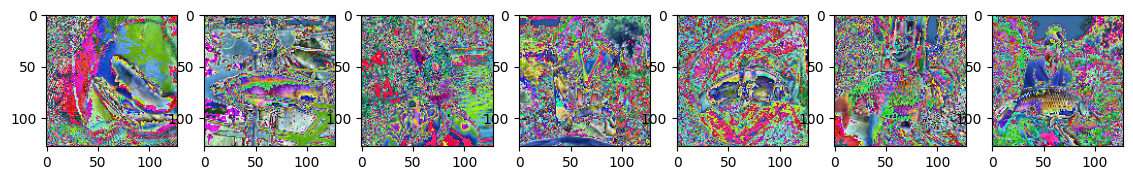

In [39]:
def show_in_row(dataset):
    plt.figure(figsize=(20, 8))
    for i in range(7):
        plt.subplot(1, 10, i + 1)
        plt.imshow(v2.ToPILImage()(dataset[i][0]))
    plt.show()


show_in_row(train_dataset)

In [40]:
class CNN(nn.Module):
    def __init__(self, num_classes, fe_dropout=0.1, cl_dropout=0.5):
        super(CNN, self).__init__()

        # Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1),  # 62x62x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 30x30x64
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 30x30x192
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 14x14x192
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 14x14x384
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 6x6x256
            nn.Dropout(p=fe_dropout),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=cl_dropout),
            nn.Linear(256 * 6 * 6, 4096),  # FC1
            nn.ReLU(inplace=True),
            nn.Dropout(p=cl_dropout),
            nn.Linear(4096, 4096),  # FC2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [41]:
num_epochs = 80
batch_size = 64
learning_rate = 0.001
out_classes = 10
checkpoint_step = 5

model = CNN(out_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=6,
    persistent_workers=True,
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=6,
    persistent_workers=True,
)
testloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=6,
)

In [42]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}"
    )

    model.eval()
    total, correct = 0, 0
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(valloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_val_loss += val_loss.item()

    accuracy = 100 * correct / total
    print(
        f"Accuracy: {accuracy:.2f}% Validation Loss: {running_val_loss / len(valloader):.4f}"
    )

    if (epoch + 1) % checkpoint_step == 0:
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": loss,
                "val_loss": val_loss,
                "accuracy": accuracy,
            },
            f"epoch_{epoch + 1}.pth",
        )

        print(f"Epoch #{epoch + 1} saved")

100%|██████████| 148/148 [00:19<00:00,  7.67it/s]


Epoch [1/80], Loss: 2.6856


100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


Accuracy: 25.54% Validation Loss: 2.0950


100%|██████████| 148/148 [00:06<00:00, 22.24it/s]


Epoch [2/80], Loss: 2.0130


100%|██████████| 41/41 [00:01<00:00, 27.92it/s]


Accuracy: 29.78% Validation Loss: 1.8329


100%|██████████| 148/148 [00:06<00:00, 22.07it/s]


Epoch [3/80], Loss: 1.9067


100%|██████████| 41/41 [00:01<00:00, 26.60it/s]


Accuracy: 32.80% Validation Loss: 1.8254


100%|██████████| 148/148 [00:06<00:00, 22.19it/s]


Epoch [4/80], Loss: 1.7855


100%|██████████| 41/41 [00:01<00:00, 26.11it/s]


Accuracy: 38.07% Validation Loss: 1.7931


100%|██████████| 148/148 [00:06<00:00, 22.08it/s]


Epoch [5/80], Loss: 1.7299


100%|██████████| 41/41 [00:01<00:00, 27.09it/s]


Accuracy: 44.00% Validation Loss: 1.6534
Epoch #5 saved


100%|██████████| 148/148 [00:06<00:00, 22.06it/s]


Epoch [6/80], Loss: 1.6820


100%|██████████| 41/41 [00:01<00:00, 27.27it/s]


Accuracy: 42.81% Validation Loss: 1.6694


100%|██████████| 148/148 [00:06<00:00, 22.01it/s]


Epoch [7/80], Loss: 1.6009


100%|██████████| 41/41 [00:01<00:00, 26.48it/s]


Accuracy: 50.08% Validation Loss: 1.4999


100%|██████████| 148/148 [00:06<00:00, 22.00it/s]


Epoch [8/80], Loss: 1.5681


100%|██████████| 41/41 [00:01<00:00, 25.77it/s]


Accuracy: 49.69% Validation Loss: 1.6122


100%|██████████| 148/148 [00:06<00:00, 21.66it/s]


Epoch [9/80], Loss: 1.5236


100%|██████████| 41/41 [00:01<00:00, 27.25it/s]


Accuracy: 52.41% Validation Loss: 1.4683


100%|██████████| 148/148 [00:06<00:00, 21.69it/s]


Epoch [10/80], Loss: 1.4378


100%|██████████| 41/41 [00:01<00:00, 27.24it/s]


Accuracy: 59.79% Validation Loss: 1.3347
Epoch #10 saved


100%|██████████| 148/148 [00:06<00:00, 21.82it/s]


Epoch [11/80], Loss: 1.4340


100%|██████████| 41/41 [00:01<00:00, 27.14it/s]


Accuracy: 60.89% Validation Loss: 1.3671


100%|██████████| 148/148 [00:06<00:00, 22.10it/s]


Epoch [12/80], Loss: 1.3755


100%|██████████| 41/41 [00:01<00:00, 26.51it/s]


Accuracy: 55.12% Validation Loss: 1.4293


100%|██████████| 148/148 [00:06<00:00, 22.10it/s]


Epoch [13/80], Loss: 1.3429


100%|██████████| 41/41 [00:01<00:00, 26.22it/s]


Accuracy: 61.81% Validation Loss: 1.2845


100%|██████████| 148/148 [00:06<00:00, 22.34it/s]


Epoch [14/80], Loss: 1.2852


100%|██████████| 41/41 [00:01<00:00, 27.13it/s]


Accuracy: 65.83% Validation Loss: 1.2036


100%|██████████| 148/148 [00:06<00:00, 21.97it/s]


Epoch [15/80], Loss: 1.2605


100%|██████████| 41/41 [00:01<00:00, 26.13it/s]


Accuracy: 65.14% Validation Loss: 1.2190
Epoch #15 saved


100%|██████████| 148/148 [00:06<00:00, 21.82it/s]


Epoch [16/80], Loss: 1.2112


100%|██████████| 41/41 [00:01<00:00, 27.00it/s]


Accuracy: 58.98% Validation Loss: 1.3936


100%|██████████| 148/148 [00:06<00:00, 22.08it/s]


Epoch [17/80], Loss: 1.1654


100%|██████████| 41/41 [00:01<00:00, 26.92it/s]


Accuracy: 66.55% Validation Loss: 1.2009


100%|██████████| 148/148 [00:06<00:00, 21.77it/s]


Epoch [18/80], Loss: 1.1267


100%|██████████| 41/41 [00:01<00:00, 26.31it/s]


Accuracy: 65.02% Validation Loss: 1.1641


100%|██████████| 148/148 [00:06<00:00, 22.00it/s]


Epoch [19/80], Loss: 1.1299


100%|██████████| 41/41 [00:01<00:00, 26.81it/s]


Accuracy: 69.50% Validation Loss: 1.0838


100%|██████████| 148/148 [00:06<00:00, 21.96it/s]


Epoch [20/80], Loss: 1.0860


100%|██████████| 41/41 [00:01<00:00, 26.52it/s]


Accuracy: 67.62% Validation Loss: 1.1545
Epoch #20 saved


100%|██████████| 148/148 [00:06<00:00, 21.83it/s]


Epoch [21/80], Loss: 1.0647


100%|██████████| 41/41 [00:01<00:00, 26.69it/s]


Accuracy: 66.59% Validation Loss: 1.1003


100%|██████████| 148/148 [00:06<00:00, 21.93it/s]


Epoch [22/80], Loss: 1.0503


100%|██████████| 41/41 [00:01<00:00, 26.03it/s]


Accuracy: 69.99% Validation Loss: 1.0819


100%|██████████| 148/148 [00:06<00:00, 22.01it/s]


Epoch [23/80], Loss: 1.0108


100%|██████████| 41/41 [00:01<00:00, 26.54it/s]


Accuracy: 71.29% Validation Loss: 0.9911


100%|██████████| 148/148 [00:06<00:00, 21.98it/s]


Epoch [24/80], Loss: 0.9604


100%|██████████| 41/41 [00:01<00:00, 27.05it/s]


Accuracy: 61.43% Validation Loss: 1.2091


100%|██████████| 148/148 [00:06<00:00, 22.03it/s]


Epoch [25/80], Loss: 0.9430


100%|██████████| 41/41 [00:01<00:00, 25.92it/s]


Accuracy: 69.23% Validation Loss: 0.9937
Epoch #25 saved


100%|██████████| 148/148 [00:06<00:00, 22.00it/s]


Epoch [26/80], Loss: 0.8952


100%|██████████| 41/41 [00:01<00:00, 26.37it/s]


Accuracy: 71.02% Validation Loss: 0.9945


100%|██████████| 148/148 [00:06<00:00, 22.05it/s]


Epoch [27/80], Loss: 0.8621


100%|██████████| 41/41 [00:01<00:00, 25.96it/s]


Accuracy: 72.02% Validation Loss: 1.0288


100%|██████████| 148/148 [00:06<00:00, 22.03it/s]


Epoch [28/80], Loss: 0.8329


100%|██████████| 41/41 [00:01<00:00, 26.49it/s]


Accuracy: 70.80% Validation Loss: 0.9467


100%|██████████| 148/148 [00:06<00:00, 21.67it/s]


Epoch [29/80], Loss: 0.8249


100%|██████████| 41/41 [00:01<00:00, 24.08it/s]


Accuracy: 71.14% Validation Loss: 0.9900


100%|██████████| 148/148 [00:06<00:00, 21.59it/s]


Epoch [30/80], Loss: 0.7624


100%|██████████| 41/41 [00:01<00:00, 24.16it/s]


Accuracy: 69.95% Validation Loss: 0.9607
Epoch #30 saved


100%|██████████| 148/148 [00:06<00:00, 21.45it/s]


Epoch [31/80], Loss: 0.7798


100%|██████████| 41/41 [00:01<00:00, 23.71it/s]


Accuracy: 70.76% Validation Loss: 0.9668


100%|██████████| 148/148 [00:06<00:00, 21.58it/s]


Epoch [32/80], Loss: 0.7352


100%|██████████| 41/41 [00:01<00:00, 23.66it/s]


Accuracy: 73.13% Validation Loss: 0.9218


100%|██████████| 148/148 [00:06<00:00, 21.59it/s]


Epoch [33/80], Loss: 0.7043


100%|██████████| 41/41 [00:01<00:00, 23.95it/s]


Accuracy: 74.81% Validation Loss: 0.8755


100%|██████████| 148/148 [00:06<00:00, 21.50it/s]


Epoch [34/80], Loss: 0.7019


100%|██████████| 41/41 [00:01<00:00, 23.63it/s]


Accuracy: 68.46% Validation Loss: 0.9973


100%|██████████| 148/148 [00:06<00:00, 21.46it/s]


Epoch [35/80], Loss: 0.6546


100%|██████████| 41/41 [00:01<00:00, 23.81it/s]


Accuracy: 73.89% Validation Loss: 0.7986
Epoch #35 saved


100%|██████████| 148/148 [00:06<00:00, 21.38it/s]


Epoch [36/80], Loss: 0.6479


100%|██████████| 41/41 [00:01<00:00, 24.21it/s]


Accuracy: 74.85% Validation Loss: 0.8219


100%|██████████| 148/148 [00:06<00:00, 21.45it/s]


Epoch [37/80], Loss: 0.6293


100%|██████████| 41/41 [00:01<00:00, 24.27it/s]


Accuracy: 76.30% Validation Loss: 0.8131


100%|██████████| 148/148 [00:06<00:00, 21.37it/s]


Epoch [38/80], Loss: 0.5900


100%|██████████| 41/41 [00:01<00:00, 24.50it/s]


Accuracy: 72.78% Validation Loss: 0.9035


100%|██████████| 148/148 [00:06<00:00, 21.22it/s]


Epoch [39/80], Loss: 0.5730


100%|██████████| 41/41 [00:01<00:00, 24.21it/s]


Accuracy: 74.89% Validation Loss: 0.7971


100%|██████████| 148/148 [00:06<00:00, 21.48it/s]


Epoch [40/80], Loss: 0.5492


100%|██████████| 41/41 [00:01<00:00, 24.05it/s]


Accuracy: 74.08% Validation Loss: 0.8097
Epoch #40 saved


100%|██████████| 148/148 [00:07<00:00, 21.11it/s]


Epoch [41/80], Loss: 0.5491


100%|██████████| 41/41 [00:01<00:00, 24.22it/s]


Accuracy: 79.40% Validation Loss: 0.7254


100%|██████████| 148/148 [00:06<00:00, 21.56it/s]


Epoch [42/80], Loss: 0.5115


100%|██████████| 41/41 [00:01<00:00, 23.89it/s]


Accuracy: 77.64% Validation Loss: 0.7651


100%|██████████| 148/148 [00:06<00:00, 21.39it/s]


Epoch [43/80], Loss: 0.4979


100%|██████████| 41/41 [00:01<00:00, 24.20it/s]


Accuracy: 74.20% Validation Loss: 0.8095


100%|██████████| 148/148 [00:06<00:00, 21.31it/s]


Epoch [44/80], Loss: 0.4884


100%|██████████| 41/41 [00:01<00:00, 24.26it/s]


Accuracy: 78.75% Validation Loss: 0.6757


100%|██████████| 148/148 [00:06<00:00, 21.52it/s]


Epoch [45/80], Loss: 0.4512


100%|██████████| 41/41 [00:01<00:00, 23.76it/s]


Accuracy: 75.88% Validation Loss: 0.9430
Epoch #45 saved


100%|██████████| 148/148 [00:06<00:00, 21.45it/s]


Epoch [46/80], Loss: 0.4560


100%|██████████| 41/41 [00:01<00:00, 23.64it/s]


Accuracy: 75.46% Validation Loss: 0.7998


100%|██████████| 148/148 [00:06<00:00, 21.63it/s]


Epoch [47/80], Loss: 0.4312


100%|██████████| 41/41 [00:01<00:00, 24.57it/s]


Accuracy: 77.87% Validation Loss: 0.6832


100%|██████████| 148/148 [00:06<00:00, 21.53it/s]


Epoch [48/80], Loss: 0.4122


100%|██████████| 41/41 [00:01<00:00, 25.10it/s]


Accuracy: 81.00% Validation Loss: 0.6118


100%|██████████| 148/148 [00:06<00:00, 21.55it/s]


Epoch [49/80], Loss: 0.4226


100%|██████████| 41/41 [00:01<00:00, 24.00it/s]


Accuracy: 80.73% Validation Loss: 0.6376


100%|██████████| 148/148 [00:06<00:00, 21.36it/s]


Epoch [50/80], Loss: 0.3837


100%|██████████| 41/41 [00:01<00:00, 24.55it/s]


Accuracy: 81.08% Validation Loss: 0.6068
Epoch #50 saved


100%|██████████| 148/148 [00:06<00:00, 21.50it/s]


Epoch [51/80], Loss: 0.3888


100%|██████████| 41/41 [00:01<00:00, 24.78it/s]


Accuracy: 79.59% Validation Loss: 0.6527


100%|██████████| 148/148 [00:06<00:00, 21.69it/s]


Epoch [52/80], Loss: 0.3686


100%|██████████| 41/41 [00:01<00:00, 24.93it/s]


Accuracy: 81.27% Validation Loss: 0.6137


100%|██████████| 148/148 [00:06<00:00, 21.52it/s]


Epoch [53/80], Loss: 0.3592


100%|██████████| 41/41 [00:01<00:00, 24.38it/s]


Accuracy: 71.33% Validation Loss: 0.8719


100%|██████████| 148/148 [00:06<00:00, 21.68it/s]


Epoch [54/80], Loss: 0.3604


100%|██████████| 41/41 [00:01<00:00, 24.23it/s]


Accuracy: 80.96% Validation Loss: 0.6437


100%|██████████| 148/148 [00:06<00:00, 21.46it/s]


Epoch [55/80], Loss: 0.3294


100%|██████████| 41/41 [00:01<00:00, 24.03it/s]


Accuracy: 79.74% Validation Loss: 0.6612
Epoch #55 saved


100%|██████████| 148/148 [00:06<00:00, 21.36it/s]


Epoch [56/80], Loss: 0.3077


100%|██████████| 41/41 [00:01<00:00, 24.86it/s]


Accuracy: 82.53% Validation Loss: 0.6243


100%|██████████| 148/148 [00:06<00:00, 21.60it/s]


Epoch [57/80], Loss: 0.3064


100%|██████████| 41/41 [00:01<00:00, 24.28it/s]


Accuracy: 78.17% Validation Loss: 0.6780


100%|██████████| 148/148 [00:06<00:00, 21.48it/s]


Epoch [58/80], Loss: 0.2981


100%|██████████| 41/41 [00:01<00:00, 24.66it/s]


Accuracy: 79.89% Validation Loss: 0.7018


100%|██████████| 148/148 [00:06<00:00, 21.50it/s]


Epoch [59/80], Loss: 0.3006


100%|██████████| 41/41 [00:01<00:00, 24.83it/s]


Accuracy: 81.65% Validation Loss: 0.5930


100%|██████████| 148/148 [00:06<00:00, 21.68it/s]


Epoch [60/80], Loss: 0.2843


100%|██████████| 41/41 [00:01<00:00, 24.89it/s]


Accuracy: 79.51% Validation Loss: 0.6644
Epoch #60 saved


100%|██████████| 148/148 [00:06<00:00, 21.22it/s]


Epoch [61/80], Loss: 0.2882


100%|██████████| 41/41 [00:01<00:00, 24.42it/s]


Accuracy: 79.89% Validation Loss: 0.6507


100%|██████████| 148/148 [00:06<00:00, 21.54it/s]


Epoch [62/80], Loss: 0.2669


100%|██████████| 41/41 [00:01<00:00, 24.14it/s]


Accuracy: 80.85% Validation Loss: 0.6126


100%|██████████| 148/148 [00:06<00:00, 21.60it/s]


Epoch [63/80], Loss: 0.2535


100%|██████████| 41/41 [00:01<00:00, 24.78it/s]


Accuracy: 80.58% Validation Loss: 0.6793


100%|██████████| 148/148 [00:06<00:00, 21.57it/s]


Epoch [64/80], Loss: 0.2676


100%|██████████| 41/41 [00:01<00:00, 24.46it/s]


Accuracy: 78.17% Validation Loss: 0.7273


100%|██████████| 148/148 [00:06<00:00, 21.41it/s]


Epoch [65/80], Loss: 0.2402


100%|██████████| 41/41 [00:01<00:00, 24.43it/s]


Accuracy: 81.57% Validation Loss: 0.6158
Epoch #65 saved


100%|██████████| 148/148 [00:06<00:00, 21.57it/s]


Epoch [66/80], Loss: 0.2589


100%|██████████| 41/41 [00:01<00:00, 24.13it/s]


Accuracy: 81.27% Validation Loss: 0.5830


100%|██████████| 148/148 [00:06<00:00, 21.58it/s]


Epoch [67/80], Loss: 0.2261


100%|██████████| 41/41 [00:01<00:00, 24.57it/s]


Accuracy: 82.80% Validation Loss: 0.6037


100%|██████████| 148/148 [00:06<00:00, 21.55it/s]


Epoch [68/80], Loss: 0.2077


100%|██████████| 41/41 [00:01<00:00, 23.59it/s]


Accuracy: 81.80% Validation Loss: 0.6214


100%|██████████| 148/148 [00:06<00:00, 21.24it/s]


Epoch [69/80], Loss: 0.2170


100%|██████████| 41/41 [00:01<00:00, 24.44it/s]


Accuracy: 80.47% Validation Loss: 0.6578


100%|██████████| 148/148 [00:06<00:00, 21.39it/s]


Epoch [70/80], Loss: 0.2004


100%|██████████| 41/41 [00:01<00:00, 24.48it/s]


Accuracy: 82.38% Validation Loss: 0.6271
Epoch #70 saved


100%|██████████| 148/148 [00:06<00:00, 21.26it/s]


Epoch [71/80], Loss: 0.2243


100%|██████████| 41/41 [00:01<00:00, 24.31it/s]


Accuracy: 78.94% Validation Loss: 0.7251


100%|██████████| 148/148 [00:06<00:00, 21.27it/s]


Epoch [72/80], Loss: 0.2047


100%|██████████| 41/41 [00:01<00:00, 24.44it/s]


Accuracy: 79.55% Validation Loss: 0.7165


100%|██████████| 148/148 [00:06<00:00, 21.61it/s]


Epoch [73/80], Loss: 0.1907


100%|██████████| 41/41 [00:01<00:00, 24.75it/s]


Accuracy: 80.12% Validation Loss: 0.6666


100%|██████████| 148/148 [00:06<00:00, 21.49it/s]


Epoch [74/80], Loss: 0.1863


100%|██████████| 41/41 [00:01<00:00, 25.03it/s]


Accuracy: 82.03% Validation Loss: 0.6563


100%|██████████| 148/148 [00:06<00:00, 21.49it/s]


Epoch [75/80], Loss: 0.1959


100%|██████████| 41/41 [00:01<00:00, 24.34it/s]


Accuracy: 82.91% Validation Loss: 0.6031
Epoch #75 saved


100%|██████████| 148/148 [00:07<00:00, 20.96it/s]


Epoch [76/80], Loss: 0.1787


100%|██████████| 41/41 [00:01<00:00, 23.95it/s]


Accuracy: 80.08% Validation Loss: 0.8679


100%|██████████| 148/148 [00:06<00:00, 21.44it/s]


Epoch [77/80], Loss: 0.1907


100%|██████████| 41/41 [00:01<00:00, 23.77it/s]


Accuracy: 80.66% Validation Loss: 0.6854


100%|██████████| 148/148 [00:06<00:00, 21.59it/s]


Epoch [78/80], Loss: 0.1551


100%|██████████| 41/41 [00:01<00:00, 24.34it/s]


Accuracy: 82.61% Validation Loss: 0.6580


100%|██████████| 148/148 [00:06<00:00, 21.48it/s]


Epoch [79/80], Loss: 0.1531


100%|██████████| 41/41 [00:01<00:00, 23.87it/s]


Accuracy: 80.24% Validation Loss: 0.7399


100%|██████████| 148/148 [00:06<00:00, 21.42it/s]


Epoch [80/80], Loss: 0.1681


100%|██████████| 41/41 [00:01<00:00, 24.18it/s]


Accuracy: 80.62% Validation Loss: 0.7862
Epoch #80 saved


In [43]:
model.eval()
total, correct = 0, 0
running_test_loss = 0.0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        test_loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_test_loss += test_loss.item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}% Test Loss: {running_test_loss / len(testloader):.4f}")

100%|██████████| 21/21 [00:16<00:00,  1.31it/s]

Accuracy: 81.44% Test Loss: 0.7361
